In [ ]:
# import all the necessary libraries
import numpy as np
import pandas as pd

from sklearn.utils import resample
from sklearn.preprocessing import normalize, OneHotEncoder
from sklearn.model_selection import GridSearchCV

import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Dense, LSTM, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier

import matplotlib.pyplot as plt

In [ ]:
# data required for the problem
alphabet = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"

# number of letters in alphabet
VOCAB_SIZE = len(alphabet)

In [ ]:
# function to get character maps
def get_maps(characters):
  # dictionary of character to indices mapping
  char_to_indx = {characters[idx]:idx for idx in range(len(characters))}
  # reverse dictionary
  indx_to_char = {v:k for (k, v) in char_to_indx.items()}
  
  print(char_to_indx)
  print(indx_to_char)
  return char_to_indx, indx_to_char

# function to create a dataset from character mappings
def get_dataset_from_maps(char_indx, indx_char):
  
  # get the size of the dictionary
  dict_size = len(indx_char)
  
  # get a random sample of character indices 
  X = resample(list(indx_char.keys()), n_samples=512, random_state=0)
  # make an array and reshape
  X = np.array(X).reshape(-1, 1)

  # get their corresponding next characters
  y = [(X_indx + 1)%(dict_size) for X_indx in X]
  # make an array and reshape
  y = np.array(y).reshape(-1, 1)

  # normalize X_indices
  #X = X/25

  # # create an array from the list and reshape it into (samples, timestep, features)
  # normalized_X = np.array(normalized_X).reshape((-1, 1, 1))

  return (X, y)

# function to one hot encode the values
def one_hot_encode(data, vocab_size):
  
  # one hot encode values
  one_hot_data = np.eye(vocab_size)[data]
  one_hot_data = one_hot_data.reshape((-1, vocab_size))

  return one_hot_data

# Define the model
def LSTM_model(layers = 2, units = 4, vocab_size = VOCAB_SIZE, embed_dim = 64, rate = 0.001):
  
  input = Input(shape = (1))

  # creates embedding layer
  x = Embedding(vocab_size, embed_dim)(input)

  # creates n-2 number of layers with similar parameters
  for _ in range(layers-2):
    x = LSTM(units, return_sequences= True)(x)
  
  # create final layer with settings
  x = LSTM(units)(x)

  # reshape so that it is consistent with the labels shape
  #x = Reshape((1,-1))(x)

  x = Dense(64, activation = 'relu')(x)
  x = Dense(32, activation = 'relu')(x)
  
  # creates output layer with softmax to get probabilities of next character
  output = Dense(vocab_size, activation = 'softmax') (x)

  # creates model the has the graph from input to the output  
  model = Model(inputs=input, outputs = output)

  # compile the model
  model.compile(loss='categorical_crossentropy', optimizer = Adam(rate), metrics = ['accuracy'])

  return model

def plot_comparision_graphs(history1, history2):

  plt.plot(history1.history['accuracy'], 'b', label = 'model1')
  plt.plot(history2.history['accuracy'], 'r', label = 'model2')
  plt.title('accuracy comparision')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend()
  plt.show()

  plt.plot(history1.history['loss'], 'b', label = 'model1')
  plt.plot(history2.history['loss'], 'r', label = 'model2')
  plt.title('loss comparison')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend()
  plt.show()


# function to find the best parameters
def plot_tuning_results(X, y, vocab_size = VOCAB_SIZE):
  clf = KerasClassifier(build_fn=LSTM_model, epochs=25, batch_size=32, verbose = 0)

  params={ 'units': [2,4,8], 
           'layers': [2, 3, 4], 
           'rate': [0.001, 0.002]}
  
  # perform grid search
  gs = GridSearchCV(estimator=clf, param_grid = params, cv=5)
  gs = gs.fit(X, y)

  return (gs.best_params_, gs.cv_results_)


def print_predictions(model, testing_samples, index_letter_map, letter_index_map):
  
  ''' 
  args:
        testing samples: a list of letters
        model: a trained model
        index_letter_map: a dictionary mapping from numbers to corresponding letters in alphabet
        letter_index_map: a dictionary mapping from letters to numbers
                                                                          '''
  
  # map characters to indices for training
  testing_data = [letter_index_map[char] for char in testing_samples]
  # create an array and reshape it for feeding it to a model
  testing_batch = np.array(testing_data).reshape((-1, 1))
  # get predictions
  predictions = model.predict(testing_batch).reshape((-1, 26))

  # get the most probable index from for each prediction
  indices = list(np.argmax(predictions, axis = 1))
  # map the indices back to letters
  letters = [index_letter_map[indx] for indx in indices]
  
  # print the input and the correspoding output
  for i in range(len(testing_samples)):
    print(f'{testing_samples[i]} --> {letters[i]}' )


In [ ]:
char_to_indx, indx_to_char = get_maps(alphabet)

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25}
{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z'}


In [ ]:
# creates dataset
X, y = get_dataset_from_maps(char_to_indx, indx_to_char)

# one hot encode y
y = one_hot_encode(y, VOCAB_SIZE)

# builds the model
model  = LSTM_model(units = 8)

# summarizes the model
model.summary()

# fit the model
history = model.fit(x = X, y = y, batch_size = 32, epochs = 15)

Model: "model_187"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_188 (InputLayer)      [(None, 1)]               0         
                                                                 
 embedding_187 (Embedding)   (None, 1, 64)             1664      
                                                                 
 lstm_369 (LSTM)             (None, 8)                 2336      
                                                                 
 dense_561 (Dense)           (None, 64)                576       
                                                                 
 dense_562 (Dense)           (None, 32)                2080      
                                                                 
 dense_563 (Dense)           (None, 26)                858       
                                                                 
Total params: 7,514
Trainable params: 7,514
Non-trainable

In [ ]:
# sample predictions
sample_data = ['A', 'D', 'K', 'O', 'S', 'U', 'Z']
print_predictions(model, sample_data, indx_to_char, char_to_indx)

A --> B
D --> E
K --> L
O --> P
S --> T
U --> V
Z --> A


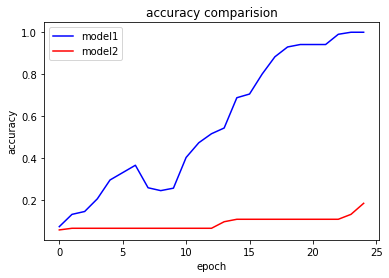

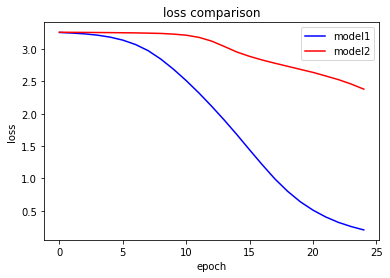

In [ ]:
# builds 2 models
model1  = LSTM_model(units = 8, layers = 2)
model2  = LSTM_model(units = 8, layers = 4)

# captures their histories
history1 = model1.fit(x = X, y = y, batch_size = 64, epochs = 25, verbose = 0)
history2 = model2.fit(x = X, y = y, batch_size = 64, epochs = 25, verbose = 0)

# draws comparision graphs
plot_comparision_graphs(history1, history2)

In [ ]:
# find the best hyperparameters
(best_params, results) = plot_tuning_results(X, y)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


In [ ]:
# print the best parameters
print(f"The best parameters found using grid search are {best_params}")

# make a data frame of the results
df = pd.DataFrame(results)

# columns to display
columns = ['mean_fit_time', 'mean_score_time', 'param_layers', 'param_rate', 'param_units', 'mean_test_score', 'rank_test_score']

# display the data frame
display(df[columns])

The best parameters found using grid search are {'layers': 2, 'rate': 0.001, 'units': 4}


,mean_fit_time,mean_score_time,param_layers,param_rate,param_units,mean_test_score,rank_test_score
0,3.534422,0.473144,2,0.001,2,0.755930,9
1,3.303113,0.469536,2,0.001,4,1.000000,1
2,3.397546,0.495829,2,0.001,8,1.000000,1
3,4.172864,0.589001,2,0.002,2,0.986408,5
4,3.546594,0.606589,2,0.002,4,1.000000,1
5,3.286846,0.634058,2,0.002,8,1.000000,1
6,7.243657,1.202401,3,0.001,2,0.230497,16
7,4.947819,0.755137,3,0.001,4,0.484828,12
8,5.123537,0.750887,3,0.001,8,0.826118,8
9,5.250727,0.970118,3,0.002,2,0.583514,11
